<a href="https://colab.research.google.com/github/supertime1/OSA/blob/main/sleep_staging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import mne
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob

In [ ]:
def data_augmentation(signal, sf, epoch, epoch_duration, overlap=10):
    """
    
    """
    total_seconds = len(signal) // sf
    
    
    

In [ ]:
def load_data(file_path, sf=128, epoch_duration=30):

    ecg_samples = []
    ecg_labels = []
    total_epoches = 0
    
    for signal_file in glob.glob(file_path + '*[0-9].edf'):
        
        ecg_epoches = []
        
        data = mne.io.read_raw_edf(signal_file)
        ecg_ch = [i for i, v in enumerate(data.info.ch_names) if v == 'ECG']
        ecg_signal = data.get_data()[ecg_ch[0]]
        
        num_of_sample_per_epoch = sf * epoch_duration
        num_of_epoches = len(ecg_signal) // (num_of_sample_per_epoch)
        total_epoches += num_of_epoches
        
        print(f'{signal_file[-12:]} has {num_of_epoches} epoches')

        for i in range(num_of_epoches):
            ecg_epoch = ecg_signal[i*num_of_sample_per_epoch : (i+1)*num_of_sample_per_epoch]
            ecg_epoches.append(ecg_epoch)
        ecg_samples.append(ecg_epoches)
    
    for label_file in glob.glob(file_path + '*stage.txt'):
        print(f'reading {label_file}')
        ecg_labels.append(np.loadtxt(label_file))
        
    assert len(ecg_samples) == len(ecg_labels)
    
    for i in range(len(ecg_samples)):
        assert len(ecg_samples[i]) == len(ecg_labels[i])
    
    
    return ecg_samples, ecg_labels, total_epoches

In [ ]:
fp = "C:/Users/57lzhang.US04WW4008/Downloads/ucd/files/"
ecg_samples, ecg_labels, total_epoches = load_data(fp, 128, 30)

Extracting EDF parameters from C:\Users\57lzhang.US04WW4008\Downloads\ucd\files\ucddb005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
ucddb005.edf has 826 epoches
Extracting EDF parameters from C:\Users\57lzhang.US04WW4008\Downloads\ucd\files\ucddb007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
ucddb007.edf has 813 epoches
Extracting EDF parameters from C:\Users\57lzhang.US04WW4008\Downloads\ucd\files\ucddb008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
ucddb008.edf has 768 epoches
reading C:/Users/57lzhang.US04WW4008/Downloads/ucd/files\ucddb002_stage.txt
reading C:/Users/57lzhang.US04WW4008/Downloads/ucd/files\ucddb003_stage.txt
reading C:/Users/57lzhang.US04WW4008/Downloads/ucd/files\ucddb005_stage.txt
reading C:/Users/57lzhang.US04WW4008/Downloads/ucd/files\ucddb006_stage.txt
reading C:/Users/57lzhang.US04WW4008/Downloads/ucd/files\ucddb007_stage.

AssertionError: ignored

In [ ]:
# split data

# split by overall sample 
def split_data(ecg_samples, ecg_labels, total_epoches, train_ratio, test_ratio):
    num_test = int(total_epoches * test_ratio)
    num_train = int((total_epoches - num_test) * train_ratio)
    num_val = total_epoches - num_test - num_train
    
    

In [ ]:
# split by patient id 
def split_data(ecg_samples, ecg_labels, train_ratio, test_ratio):
    test_num = int(len(ecg_samples) * test_ratio)
    train_num = int(len(ecg_samples) - test_num) * train_ratio
    val_num = len(ecg_samples) - test_num - train_num

    np.random.seed(seed=seed)
    np.random.shuffle(ecg_samples)
    train_samples = ecg_samples[:train_num]
    val_samples = ecg_samples[train_num:train_num+val_num]
    test_samples = ecg_samples[-test_num:]

    np.random.seed(seed=seed)
    np.random.shuffle(ecg_labels)
    train_labels = ecg_labels[:train_num]
    val_labels = ecg_labels[train_num:train_num+val_num]
    test_labels = ecg_labels[-test_num:]

    return train_samples, train_labels, val_samples, val_labels, test_samples, test_labels 

In [ ]:
def preprocess_data(num_epoch, ecg_epoches, ecg_labels):
    """
    preprocess data with the matched dimension for training
    [num_epoch, 30*sampling_frequency, 1]

    params:
    epoch - number of epoches for each training sample
    sf - sampling frequency of ECG signal
    file_path - file path of raw EDF file
    """
    
    

In [ ]:
info = data.info
info.ch_names
info

<Info | 7 non-empty values
 bads: []
 ch_names: Lefteye, RightEye, EMG, C3A2, C4A1, ECG, SpO2, Sound, Flow, Sum, ...
 chs: 14 EEG
 custom_ref_applied: False
 highpass: 0.3 Hz
 lowpass: 35.0 Hz
 meas_date: 2003-01-01 23:57:14 UTC
 nchan: 14
 projs: []
 sfreq: 128.0 Hz
>

In [ ]:
[i for i, v in enumerate(info.ch_names) if v == 'ECG']

[5]

In [ ]:
type(info.ch_names)

list

808.9


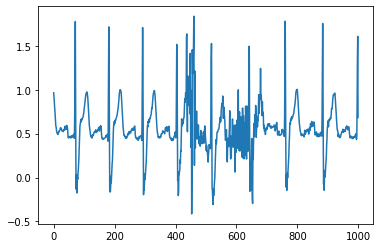

In [ ]:
ecg = raw_data[5]
print(len(ecg)/128/30)
plt.plot(ecg[:1000])

In [ ]:
ss = np.loadtxt('/Users/luffygaga/Downloads/files/ucddb006_stage.txt')
len(ss)

808

In [ ]:
lst = []
lst.append(ss)

In [ ]:
lst.append([2])